# Volumetric inverse rendering

## Overview

In this tutorial, we are going to see how to use volumetric inverse rendering to optimize a volume grid to match the appearance of a solid object (here a mesh).

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
    
<ul>
  <li>Construct a scene with volumes</li>
  <li>Optimize a volume grid to match a set of reference images</li>
  <li>Upscale the optimized parameters during the optimization</li>
</ul>
    
</div>


## Step 1 - Setup

As always, we start with the usual imports and set a variant that supports automatic differentation.

In [1]:
import matplotlib.pyplot as plt 

import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Step 2 - Create sensors

There are often many solutions to a given set of constraints when optimizing a volume grid, which often don't generalize. For instance, if we optimize a volume given a single reference image, the optimized volume is likely to only contain dense voxels in the part closer to the camera, which would look wrong from a different angle. 

Therefore, multi-view optimization must be used to optimize a volume that looks reasonable from other points of view. In this tutorial, we first create 5 sensors placed around the origin on a half circle.

In [2]:
from mitsuba.scalar_rgb import ScalarTransform4f as T

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0 
    sensor_rotation = T.rotate([0, 1, 0], angle) 
    sensor_to_world = T.look_at(
        target=[0, 0, 0],
        origin=[0, 0, 4],
        up=[0, 1, 0]
    )
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'near_clip': 1,
        'far_clip': 1000,
        'fov': 45,
        'to_world': sensor_rotation * sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 64,
            'height': 64,
            'pixel_format': 'rgb',
            'filter': { 'type': 'tent' },
        }
    }))

## Step 3 - Reference scene

Let's now create a simple scene with constant illumation and a Stanford Bunny placed at the origin. We render this with all the sensors we created in the last step and store those in an array for later use.

In [3]:
scene_dict = {
    'type': 'scene',
    'integrator': {
        'type': 'prbvolpath',
    },
    'object': {
        'type': 'ply',
        'filename': '../../scenes/meshes/bunny.ply',
        'to_world': T.scale(10.0),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': [0.3, 0.3, 0.3] },
        },
    },
    'emitter': { 'type': 'constant' }
}

scene_ref = mi.load_dict(scene_dict)

2022-04-08 15:28:34 WARN main [Scene] No sensors found! Instantiating a perspective camera..

In [4]:
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=128) for i in range(sensor_count)]

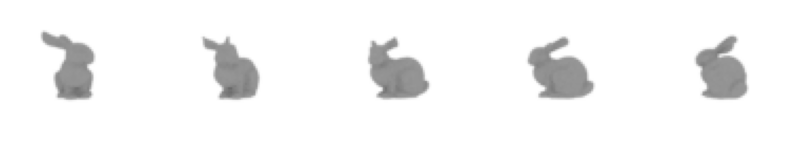

In [5]:
fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[i].axis('off')

## Step 4 - Optimization scene

We modify the scene dictionary to replace the mesh object with a simple cube that contains a heterogeneous volume. To keep it simple, we are only going to optimize the `sigma_t` parameter of the volume, hence we use a simple constant volume of the `albedo` parameter. To learn more about volumes in Mitsuba, please refer to the [plugin documentation](...).

To initialize a volume grid from Python, one should use the `VolumeGrid` object in conjunction with `TensorXf`. This class is responsible for loading and writing volumes from disk, similar to the `Bitmap` class for images. Using the `grid` property of the `gridvolume` plugin, it is possible to pass it directly to the plugin constructor in Python.

Note that we initialize the grid to a low constant value, (e.g. `0.002`). This tends to help the optimization process as in practise we find that it is easier to add to the volume rather than carving it out. 

Moreover, the grid resolution choosen here is pretty small. This is done on purpose as we are going to upscale the volume grid later in the tutorial during the optimization process. As explained later, from our experience this also helps with the convergence of the volume optimization.

In [6]:
v_res = 16

# Update the scene dictionary
scene_dict['object'] = { 
    'type': 'cube',
    'interior': {
        'type': 'heterogeneous',
        'sigma_t': {
            'type': 'gridvolume',
            'grid': mi.VolumeGrid(dr.full(mi.TensorXf, 0.002, (v_res, v_res, v_res, 1))),
            'to_world': T.translate(-1) * T.scale(2.0)
        },
        'albedo': {
            'type': 'constvolume',
            'value': { 'type': 'rgb', 'value': [0.25, 0.25, 0.25] },
        },
        'phase': {
            'type': 'isotropic'
        },
        'scale': 25.0,
        'sample_emitters': False,
    },
    'bsdf': {
        'type': 'dielectric',
        'int_ior': 'air',
    },
}

We load the modified scene and render it for all view angles. Those are going to be our initial image in the optimization process.

2022-04-08 15:28:34 WARN main [Scene] No sensors found! Instantiating a perspective camera..

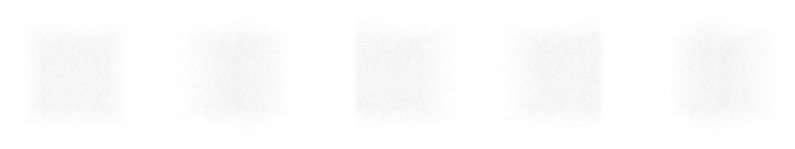

In [7]:
scene = mi.load_dict(scene_dict)

init_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(init_images[i]))
    axs[i].axis('off')

## Step 5 - Optimization

We instantiate an `Adam` optimizer and load the `sigma_t` grid data as parameter to be optimized.

In [8]:
params = mi.traverse(scene)

key = 'object.interior_medium.sigma_t.data'

opt = mi.ad.Adam(lr=0.02, params=params)
opt.load(key)
opt.update()

We perform the optimization loop for a few iterations, similarily to the other tutorials.

In [9]:
for it in range(20):
    total_loss = 0.0
    for sensor_idx in range(sensor_count):
        # Perform the differentiable light transport simulation
        img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=8, seed=it)
        
        # L2 loss function
        loss = dr.hmean_async(dr.sqr(img - ref_images[sensor_idx]))
        
        # Backpropagate gradients
        dr.backward(loss)

        # Take a gradient step
        opt.step()
        
        # Clamp the optimized values to a valid range
        opt[key] = dr.clamp(opt[key], 1e-6, 1.0)
        
        # Propagate changes to the scene
        opt.update()
        
        total_loss += loss[0]
    print(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')

## Step 6 - Intermediate results

We have only performed a few iterations so far, but let's have a look at the current result.

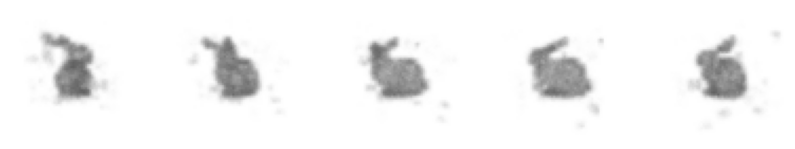

In [10]:
intermediate_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(intermediate_images[i]))
    axs[i].axis('off')

## Step 7 - Volume upscaling

The results above don't look great. On of the reason is the very low resolution of the optimized volume grid. Let's try to increase the resolution of the current grid and continue the optimization for a few more iterations.
In practice it is recommended to leverage such a "multi-resolution" approach. At low resolution, the optimization will learn the overall shape, exploring a much coarsed solution landscape. Moving on to a volume with a higher resolution allows the solution to be refined, while already starting with a good guess.

The current codebase doesn't provide any tooling for manipulating volume data, so we will need to do things manually using DrJit 🧨

The idea of the following upscaling scheme is simple: we are going to create a large array of indices that map every voxel of the new grid to a voxel in the current grid. Then we can use a `dr.gather` statement to fetch the corresponding value and create the new volume grid in one shot. 

The tricky part is to build this array of indices. We start with an increasing array with a size correpsonding to the number of voxels in the new grid. Effectivelly this array assigns a different index to all voxels in the new grid.
We also compute the `ratio` between both resolutions, which tells use how many voxels will map to a same voxel on every axis.

Using `idx` and `ratio`, it is then easy to create index array that map each voxel of the new grid to the `x`, `y`, `z` coordinates in the current grid. For instance for the first dimension (`x`) we first perform a integer division by `ratio` to stride the indices, and then compute the modulo of these indices with the current resolution to wrap the `x` indices so that they account for the `y` and `z` dimensions.

Following the same logic, we compute `idx_y` and `idx_z` which we finally combine into `index` which gives us our final mapping.

Once the `TensorXf` created using `dr.gather`, it can be used to override the optimized variable.

As always we call the `update` method on the optimizer to propagate those changes to the rest of the scene.

In [11]:
new_v_res = 64

ratio = new_v_res // v_res

idx = dr.arange(mi.UInt32, new_v_res ** 3)
idx_x = (idx // ratio) % v_res
idx_y = ((idx // new_v_res) // ratio) % v_res
idx_z = ((idx // (new_v_res ** 2)) // ratio) % v_res
index = idx_x + (idx_y + idx_z * v_res) * v_res

opt[key] = mi.TensorXf(dr.gather(mi.Float, opt[key].array, index), (new_v_res, new_v_res, new_v_res, 1))

opt.update()

By rendering the new volume, we can notice a difference in the sharpness of the volume as the resolution was increase because of the *trilinear* filtering.

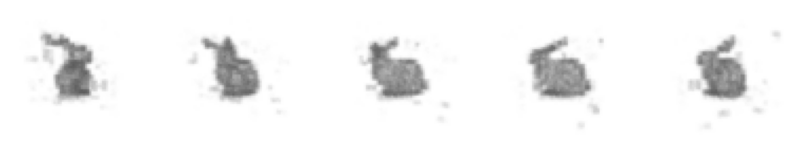

In [12]:
upscale_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(upscale_images[i]))
    axs[i].axis('off')

## Step 8 - Continue optimization

Let's now continue our optimization loop for a few more iterations with the upscaled volume grid.

Note that the optimizer automatically reset the internal state associated to the optimized variable as its data size has changed.

In [13]:
for it in range(20):
    total_loss = 0.0
    for sensor_idx in range(sensor_count):
        img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=8, seed=it)
        loss = dr.hmean_async(dr.sqr(img - ref_images[sensor_idx]))
        dr.backward(loss)
        opt.step()
        opt[key] = dr.clamp(opt[key], 1e-6, 1.0)
        opt.update()
        total_loss += loss[0]
    print(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')

## Step 9 - Final results

Finally we can render the final volume from the different view points and compare the images to the reference images.

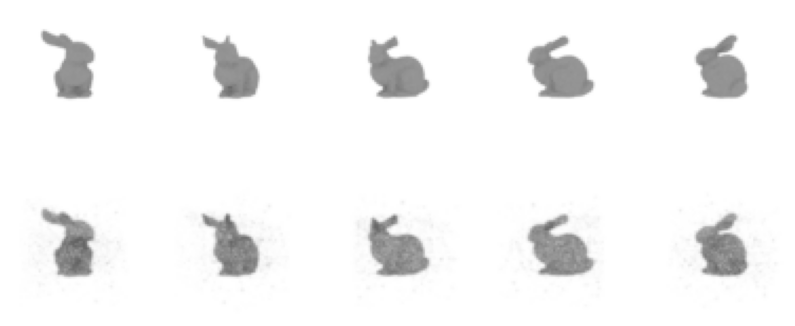

In [14]:
final_images = [mi.render(scene, sensor=sensors[i], spp=512) for i in range(sensor_count)]

fig, axs = plt.subplots(2, sensor_count, figsize=(14, 6))
for i in range(sensor_count):
    axs[0][i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[0][i].axis('off')
    axs[1][i].imshow(mi.util.convert_to_bitmap(final_images[i]))
    axs[1][i].axis('off')

<div class="admonition note alert alert-block alert-info">

📑 **See also**
    
<ul>
  <li><a href="url"><tt>mitsuba.load_dict</tt></a></li>
</ul>
    
</div>